In [11]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, GRU, Activation
from keras.callbacks import TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('../train.csv')
print(df.shape)
df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
df_train = df.copy()
# df_train['month'] = pd.DatetimeIndex(df_train['datetime']).month
df_train['day'] = pd.DatetimeIndex(df_train['datetime']).day
df_train['dayofweek'] = pd.DatetimeIndex(df_train['datetime']).dayofweek
df_train['hour'] = pd.DatetimeIndex(df_train['datetime']).hour
df_train = df_train.drop('datetime', axis=1)
y = df_train['count'].copy()
df_train = df_train.drop(['casual','registered','count'], axis=1)
x = df_train.copy()
cr_w_from = 7
cr_w_to = 23
cr_nw_from = 10
cr_nw_to = 19
rr_w_from1 = 6
rr_w_to1 = 9
rr_w_from2 = 16
rr_w_to2 = 23
rr_nw_from = 8
rr_nw_to = 23
x['casual_rush'] = x[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  cr_w_from <= x['hour'] <= cr_w_to)
        or (x['workingday'] == 0 and  cr_nw_from <= x['hour'] <= cr_nw_to)], axis = 1)
x['registered_rush'] = x[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  (rr_w_from1 <= x['hour'] <= rr_w_to1 or rr_w_from2 <= x['hour'] <= rr_w_to2))
        or (x['workingday'] == 0 and rr_nw_from <= x['hour'] <= rr_nw_to)], axis = 1)
print(x.shape)
x.head()

(10886, 13)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,day,dayofweek,hour,casual_rush,registered_rush
0,1,0,0,1,9.84,14.395,81,0.0,1,5,0,0,0
1,1,0,0,1,9.02,13.635,80,0.0,1,5,1,0,0
2,1,0,0,1,9.02,13.635,80,0.0,1,5,2,0,0
3,1,0,0,1,9.84,14.395,75,0.0,1,5,3,0,0
4,1,0,0,1,9.84,14.395,75,0.0,1,5,4,0,0


In [6]:
X = x.values
Y = y.values
n_features = X.shape[1]
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(X.shape[0], 1, n_features)
def new_model():
    # create model
    model = Sequential()
    model.add(GRU(50, input_shape=(1, n_features), return_sequences=True, activation='relu'))
    model.add(GRU(50, input_shape=(1, n_features), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.add(Activation('linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='RMSprop')
    return model
kr = KerasRegressor(build_fn=new_model, nb_epoch=100, batch_size=5, verbose=2)
# %time kr_casual.fit(X, Y, callbacks=[TensorBoard(log_dir='logs')])
%time kr.fit(X, Y)

Epoch 1/100
18s - loss: 12887.9999
Epoch 2/100
17s - loss: 9660.6378
Epoch 3/100
17s - loss: 8714.5435
Epoch 4/100
17s - loss: 8139.5404
Epoch 5/100
17s - loss: 7731.4859
Epoch 6/100
17s - loss: 7414.7264
Epoch 7/100
17s - loss: 7086.9972
Epoch 8/100
17s - loss: 6769.2224
Epoch 9/100
17s - loss: 6482.0746
Epoch 10/100
17s - loss: 6363.4330
Epoch 11/100
18s - loss: 6117.0083
Epoch 12/100
18s - loss: 6093.0005
Epoch 13/100
17s - loss: 5977.2561
Epoch 14/100
16s - loss: 5844.5628
Epoch 15/100
16s - loss: 5839.8687
Epoch 16/100
19s - loss: 5545.8242
Epoch 17/100
17s - loss: 5480.0063
Epoch 18/100
18s - loss: 5404.9040
Epoch 19/100
17s - loss: 5341.4477
Epoch 20/100
17s - loss: 5187.1175
Epoch 21/100
19s - loss: 5125.4512
Epoch 22/100
19s - loss: 4916.1012
Epoch 23/100
19s - loss: 4706.3186
Epoch 24/100
18s - loss: 4470.2134
Epoch 25/100
19s - loss: 4380.3602
Epoch 26/100
18s - loss: 4178.5054
Epoch 27/100
19s - loss: 4197.5882
Epoch 28/100
19s - loss: 4091.9327
Epoch 29/100
17s - loss: 401

## Prediction

In [7]:
df_test = pd.read_csv('../test.csv')
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [8]:
dft = df_test.copy()
# dft['month'] = pd.DatetimeIndex(dft['datetime']).month
dft['day'] = pd.DatetimeIndex(dft['datetime']).day
dft['dayofweek'] = pd.DatetimeIndex(dft['datetime']).dayofweek
dft['hour'] = pd.DatetimeIndex(dft['datetime']).hour
dft = dft.drop('datetime', axis=1)
t = dft.copy()
t['casual_rush'] = t[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  cr_w_from <= x['hour'] <= cr_w_to)
        or (x['workingday'] == 0 and  cr_nw_from <= x['hour'] <= cr_nw_to)], axis = 1)
t['registered_rush'] = t[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  (rr_w_from1 <= x['hour'] <= rr_w_to1 or rr_w_from2 <= x['hour'] <= rr_w_to2))
        or (x['workingday'] == 0 and rr_nw_from <= x['hour'] <= rr_nw_to)], axis = 1)
print(t.shape)
t.head()

(6493, 13)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,day,dayofweek,hour,casual_rush,registered_rush
0,1,0,1,1,10.66,11.365,56,26.0027,20,3,0,0,0
1,1,0,1,1,10.66,13.635,56,0.0000,20,3,1,0,0
2,1,0,1,1,10.66,13.635,56,0.0000,20,3,2,0,0
3,1,0,1,1,10.66,12.880,56,11.0014,20,3,3,0,0
4,1,0,1,1,10.66,12.880,56,11.0014,20,3,4,0,0


In [9]:
t = scaler.fit_transform(t)
t = t.reshape(t.shape[0], 1, n_features)
test_pred = kr.predict(t)
test_pred[test_pred < 0] = 0
str_prediction = "datetime,count\n"
for i in range(0, len(test_pred)):
    datetime = df_test['datetime'][i]
    pred = int(round(test_pred[i]))
    str_prediction += "{},{}\n".format(datetime, pred)

# print(str_prediction)
f = open('pred_keras_gru2.csv','w')
f.write(str_prediction)
f.close()

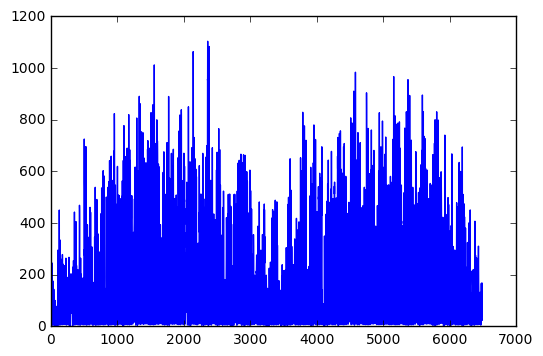

In [12]:
plt.plot(test_pred)